In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np

class logistic:
  def __init__(self, weights, bias, epochs, learning_rate, tolerance, cost_function='cross_entropy'):
    self.weights = weights
    self.bias = bias
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.tolerance = tolerance
    self.cost_function = cost_function
    self.cost_history = {
      'cross_entropy': [],
      'hinge': []
    }

  def cross_entropy_loss(self, y, y_hat):
    loss = 0
    for i in range(len(y)):
      # Add small epsilon to avoid log(0)
      epsilon = 1e-15
      y_hat[i] = max(min(y_hat[i], 1 - epsilon), epsilon)
      loss += -y[i] * math.log(y_hat[i]) - (1 - y[i]) * math.log(1 - y_hat[i])
    return loss / len(y)

  def hinge_loss(self, y, y_hat):
    loss = 0
    for i in range(len(y)):
      # Convert y to {-1, 1} for hinge loss
      y_transformed = 2 * y[i] - 1
      # Convert sigmoid output to decision values
      margin = y_transformed * (2 * y_hat[i] - 1)
      loss += max(0, 1 - margin)
    return loss / len(y)


  def compute_y_hat(self, x):
    return sum(x[i]*self.weights[i] for i in range(len(self.weights))) + self.bias

  def compute_gradient(self, X, y, cost_function):
    n_samples = len(X)
    n_features = len(X[0])
    dw = [0] * n_features
    db = 0

    for j in range(n_samples):
      y_pred = self.sigmoid(self.compute_y_hat(X[j]))

      if cost_function == 'cross_entropy':
        error = y_pred - y[j]
      elif cost_function == 'hinge':
        y_transformed = 2 * y[j] - 1
        margin = y_transformed * (2 * y_pred - 1)
        error = 0 if margin > 1 else -y_transformed * 2 * y_pred * (1 - y_pred)
      elif cost_function == 'huber':
        error = y_pred - y[j]
        if abs(error) > 1.0:  # delta = 1.0
          error = 1.0 * np.sign(error)

      for i in range(n_features):
        dw[i] += error * X[j][i]
      db += error

    dw = [dw_i / n_samples for dw_i in dw]
    db /= n_samples

    return dw, db

  def descent(self, dw, db):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learning_rate * dw[i]
    self.bias -= self.learning_rate * db

  def sigmoid(self, z):
    # Clip z to avoid overflow in exp
    z = min(max(z, -100), 100)
    return 1 / (1 + math.exp(-z))

  def fit(self, X, y, compare_costs=False):
    cost_functions = ['cross_entropy', 'hinge', 'huber'] if compare_costs else [self.cost_function]
    results = {}

    # Save initial weights and bias
    initial_weights = self.weights.copy()
    initial_bias = self.bias

    for cost_function in cost_functions:
      # Reset weights and bias to initial values for fair comparison
      self.weights = initial_weights.copy()
      self.bias = initial_bias
      self.cost_history[cost_function] = []

      prev_loss = float('inf')
      for epoch in range(self.epochs):
        y_hat = [self.sigmoid(self.compute_y_hat(X[i])) for i in range(len(X))]

        if cost_function == 'cross_entropy':
          loss = self.cross_entropy_loss(y, y_hat)
        elif cost_function == 'hinge':
          loss = self.hinge_loss(y, y_hat)

        self.cost_history[cost_function].append(loss)

        dw, db = self.compute_gradient(X, y, cost_function)
        self.descent(dw, db)

        if abs(prev_loss - loss) < self.tolerance:
          print(f"Converged at epoch {epoch+1} using {cost_function} loss")
          break

        prev_loss = loss

      # Store final weights and bias for this cost function
      results[cost_function] = {
        'weights': self.weights.copy(),
        'bias': self.bias
      }

    # Restore weights to the selected cost function if comparing
    if compare_costs:
      self.weights = results[self.cost_function]['weights']
      self.bias = results[self.cost_function]['bias']

    return results if compare_costs else None

  def predict(self, X):
    return [self.sigmoid(self.compute_y_hat(x)) for x in X]

  def visualize_cost(self, cost_functions=None):
    """Visualize how different cost functions change over epochs."""
    if cost_functions is None:
      cost_functions = [self.cost_function]

    plt.figure(figsize=(12, 8))

    for cost_function in cost_functions:
      if len(self.cost_history[cost_function]) > 0:
        plt.plot(
          range(1, len(self.cost_history[cost_function]) + 1),
          self.cost_history[cost_function],
          marker='o' if len(self.cost_history[cost_function]) < 50 else None,
          linestyle='-',
          label=f'{cost_function.replace("_", " ").title()} Loss'
        )

    plt.title('Cost Functions Comparison Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add annotations for initial and final costs
    for cost_function in cost_functions:
      history = self.cost_history[cost_function]
      if len(history) > 0:
        plt.annotate(
          f'Initial {cost_function}: {history[0]:.4f}',
          xy=(1, history[0]),
          xytext=(len(history)//10, history[0] * 1.1),
          arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8)
        )

        plt.annotate(
          f'Final {cost_function}: {history[-1]:.4f}',
          xy=(len(history), history[-1]),
          xytext=(len(history) - len(history)//5, history[-1] * 1.1),
          arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8)
        )

    plt.show()

  def compare_cost_functions(self, X, y):
    """Train using all cost functions and visualize their comparison."""
    # Train with all cost functions
    self.fit(X, y, compare_costs=True)

    # Visualize all cost functions
    self.visualize_cost(['cross_entropy', 'hinge', 'huber'])

    # Print final statistics
    for cost_function in ['cross_entropy', 'hinge', 'huber']:
      history = self.cost_history[cost_function]
      if len(history) > 0:
        print(f"{cost_function.replace('_', ' ').title()} Loss:")
        print(f"  Initial Cost: {history[0]:.6f}")
        print(f"  Final Cost: {history[-1]:.6f}")
        print(f"  Improvement: {(1 - history[-1]/history[0])*100:.2f}%")
        print(f"  Convergence: {len(history)} epochs")
        print()

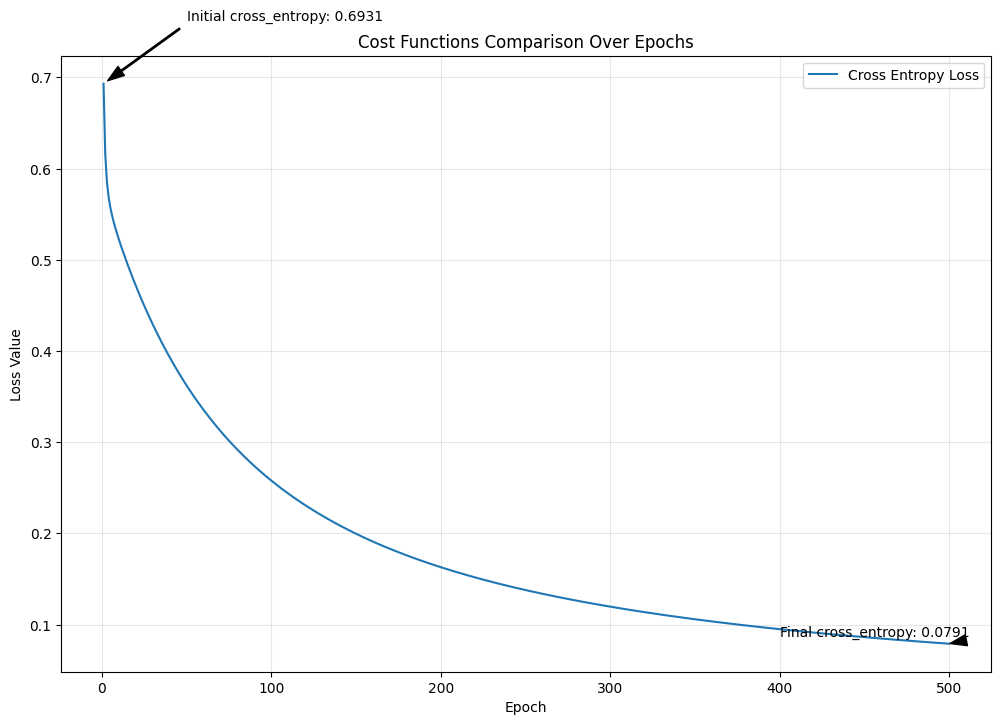

In [14]:
X = [
    [5, 10], [0, 2], [1, 3], [8, 10], [3, 5],  # Spam emails (1)
    [0, 0], [2, 1], [1, 0], [3, 2], [1, 1]   # Non-spam emails (0)
]
y = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.05, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()


Converged at epoch 285 using cross_entropy loss


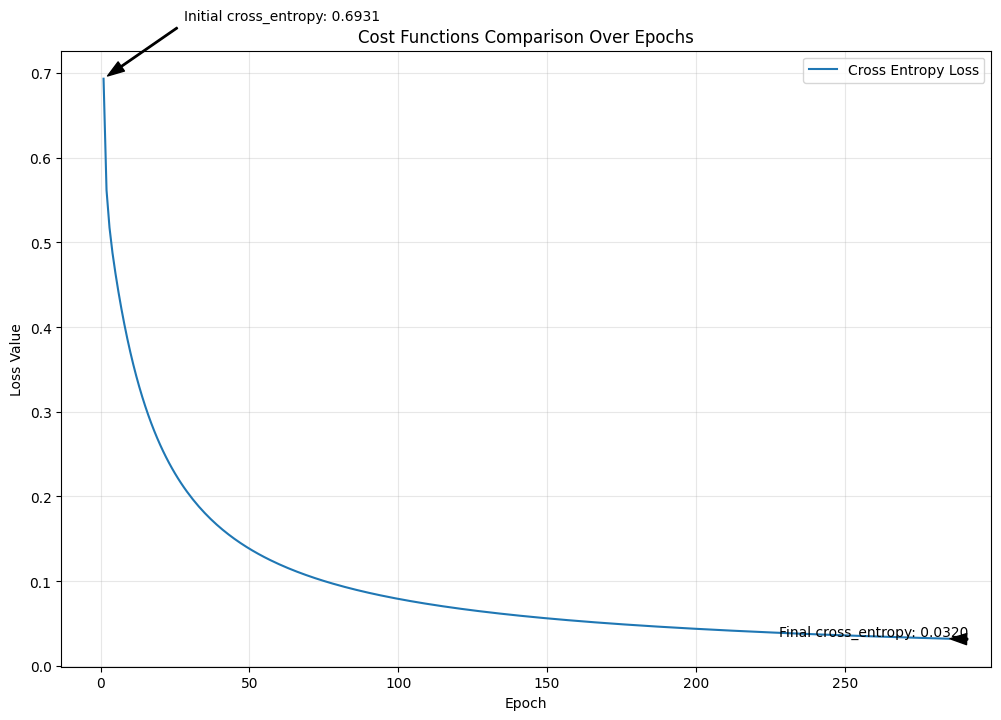

In [15]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.25, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()

Converged at epoch 207 using cross_entropy loss


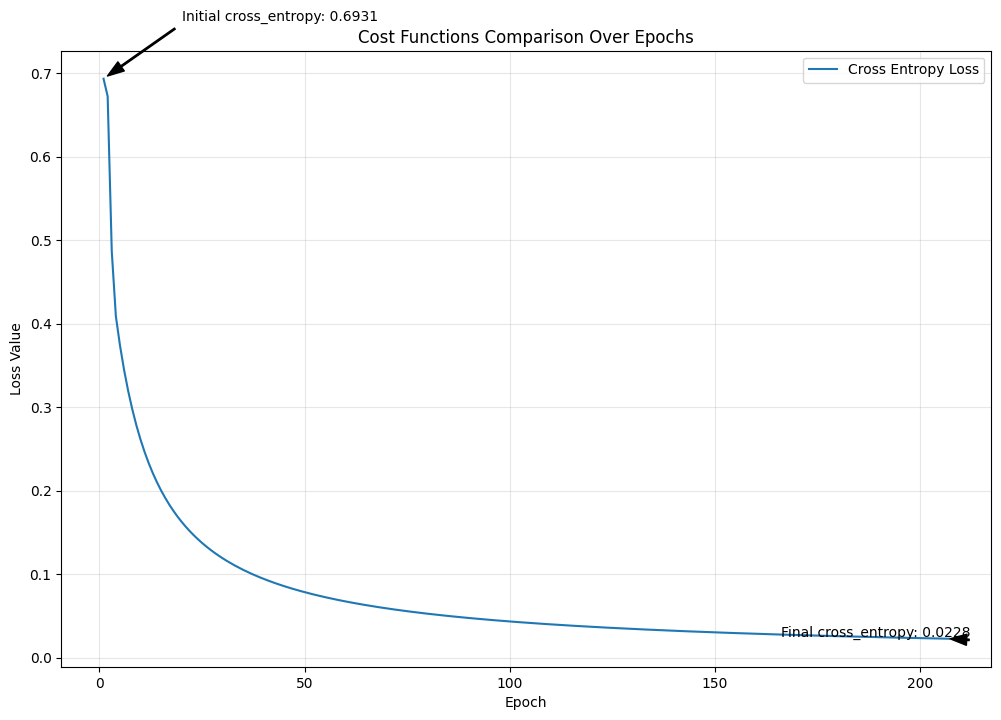

In [16]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.5, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()

Converged at epoch 157 using cross_entropy loss


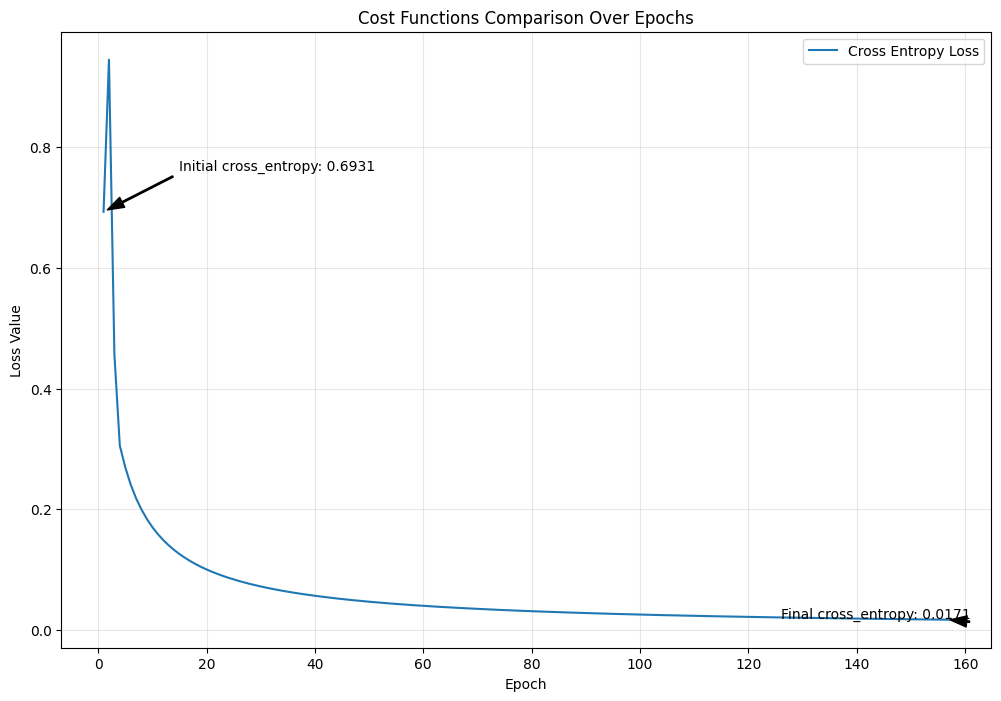

In [17]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.9, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()

Converged at epoch 122 using cross_entropy loss


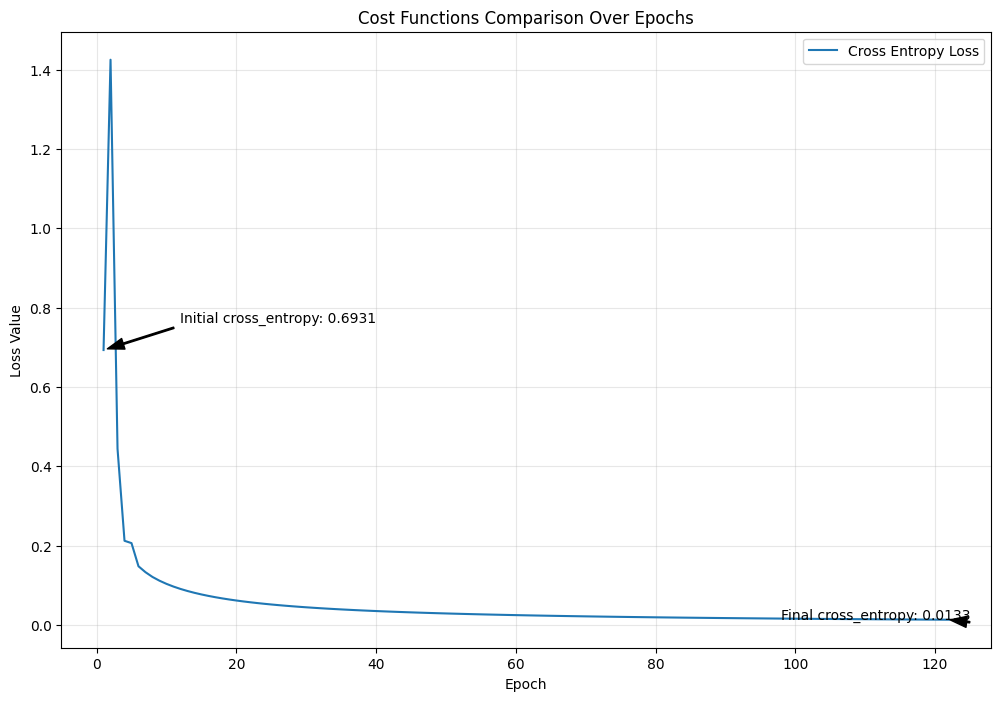

In [18]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=1.5, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()

Converged at epoch 104 using cross_entropy loss


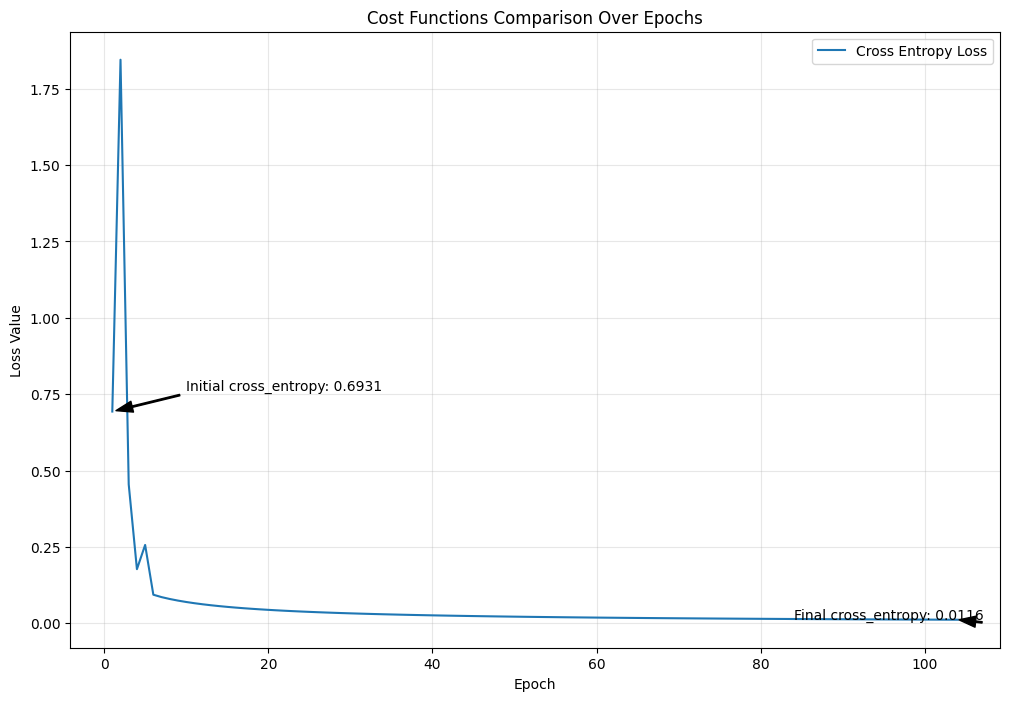

In [19]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=2, tolerance=1e-4)
model.fit(X, y)
model.visualize_cost()#wow higher numbers do wonders

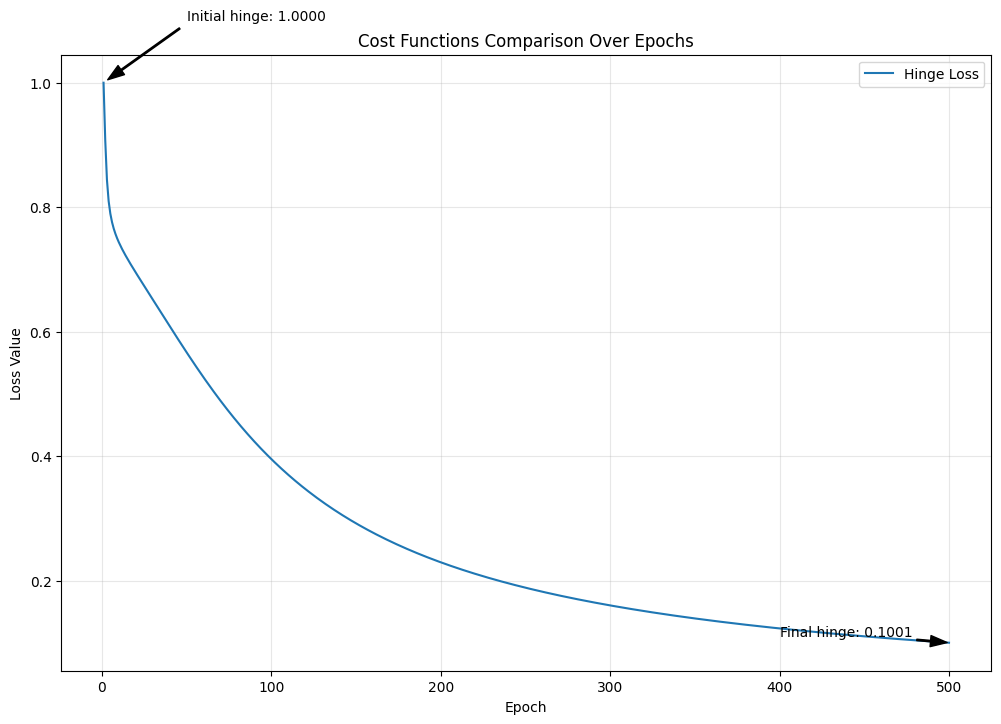

In [22]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=0.05, tolerance=1e-4,cost_function="hinge")
model.fit(X, y)
model.visualize_cost()

Converged at epoch 320 using hinge loss


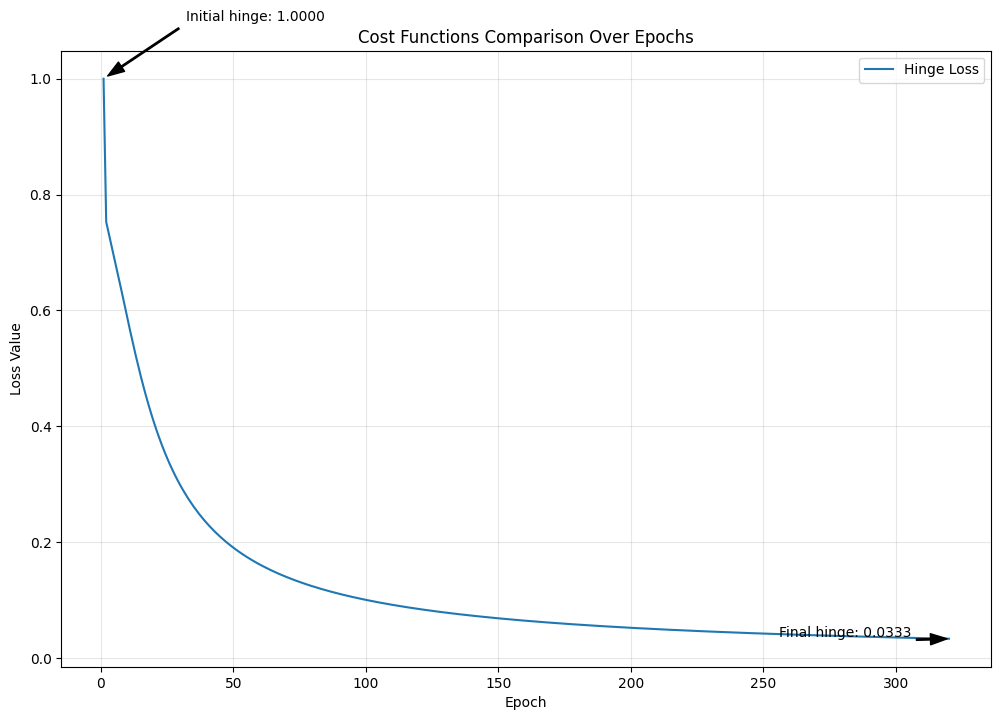

In [23]:
model = logistic(weights=[0, 0], bias=0, epochs=1000, learning_rate=0.25, tolerance=1e-4,cost_function="hinge")
model.fit(X, y)
model.visualize_cost()

Converged at epoch 164 using hinge loss


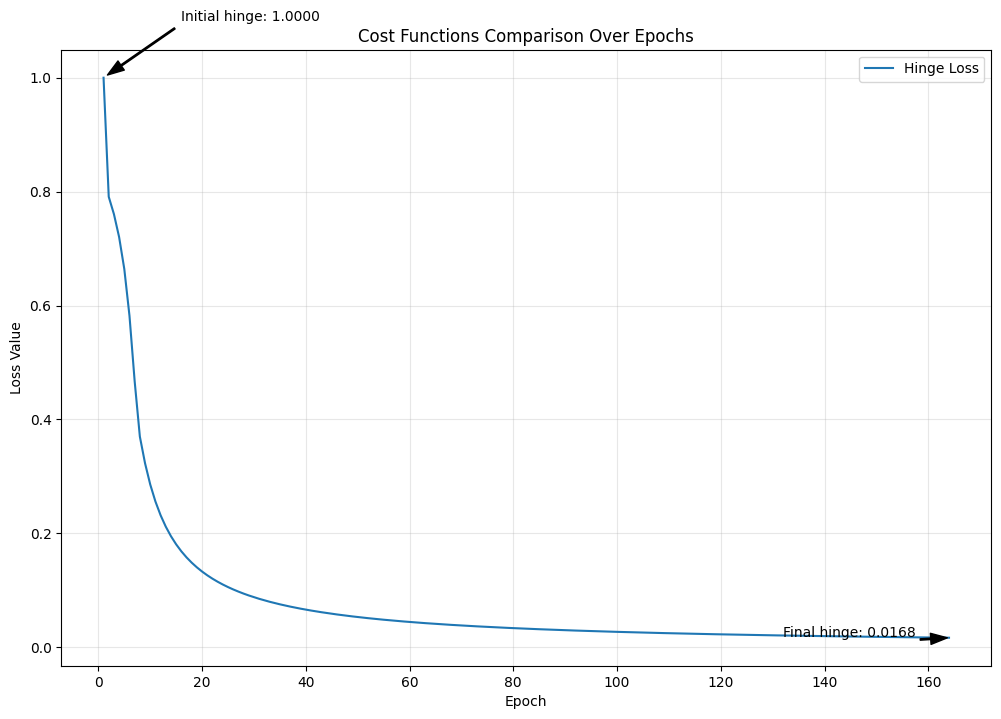

In [24]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=1, tolerance=1e-4,cost_function="hinge")
model.fit(X, y)
model.visualize_cost()

Converged at epoch 135 using hinge loss


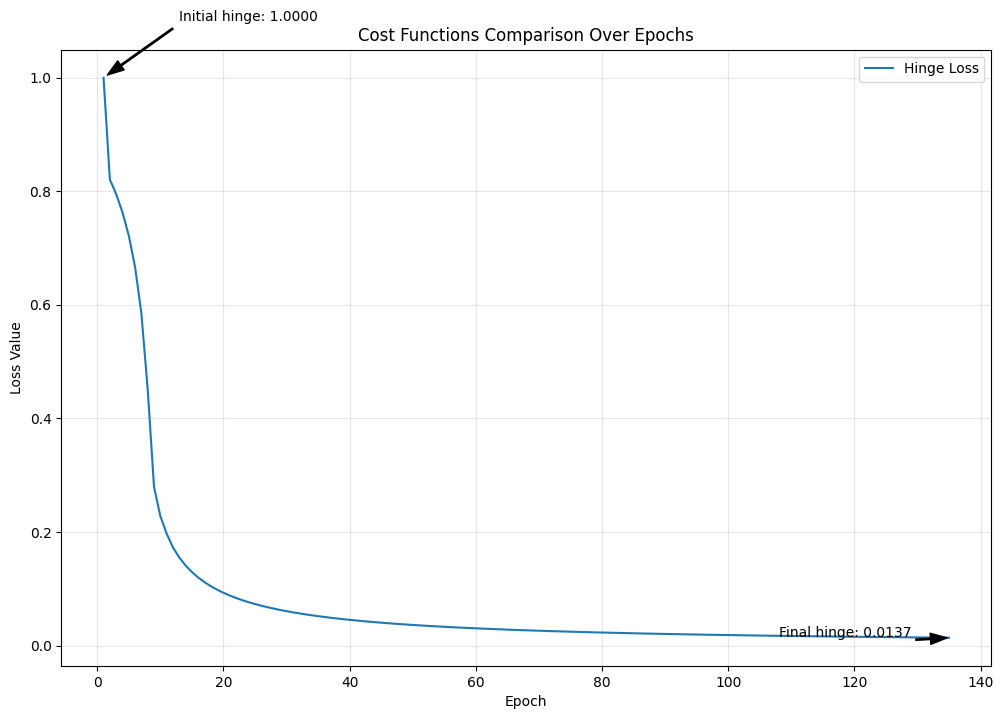

In [25]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=1.5, tolerance=1e-4,cost_function="hinge")
model.fit(X, y)
model.visualize_cost()

Converged at epoch 117 using hinge loss


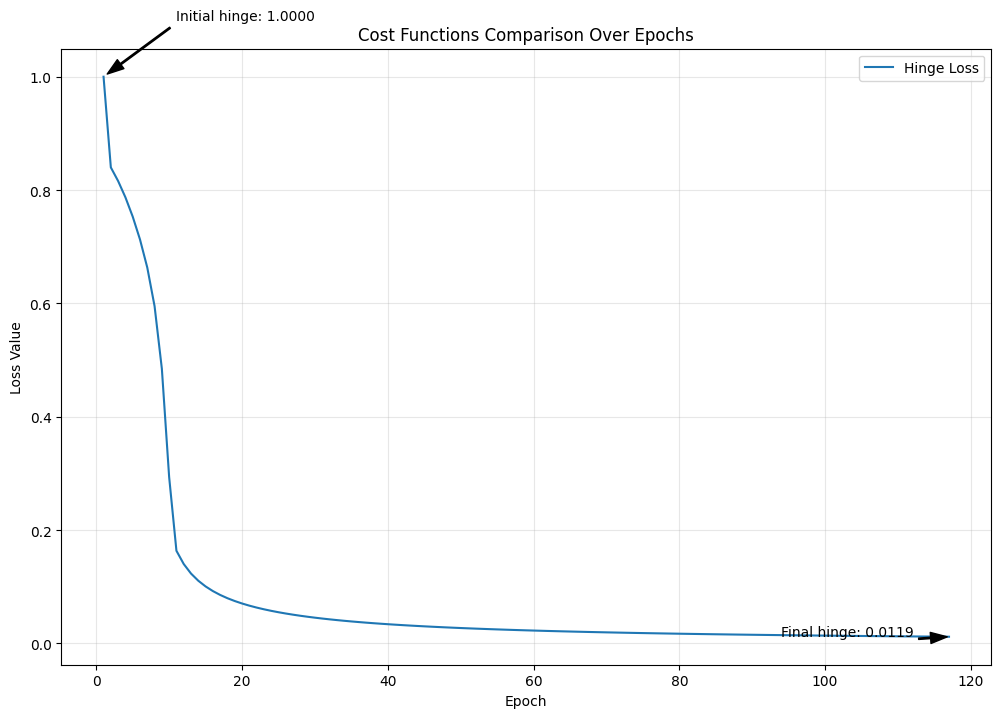

In [26]:
model = logistic(weights=[0, 0], bias=0, epochs=500, learning_rate=2, tolerance=1e-4,cost_function="hinge")
model.fit(X, y)
model.visualize_cost()
#cross entropy provides better results(more accurate) within lower epochs